In [82]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from array import array
import fsps

In [83]:
#to order and match the spec with their z values
spec_atr = Table.read('/home/sebastian/Spectra/Spec Attributes.txt', format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring = '/home/sebastian/Spectra/spec/'

init_spec = []

init_z = []

for entry in spec_atr:
    
    if entry["zspec"] > 0.00:
        
        temp = XSpectrum1D.from_file(basestring + entry['Filename'])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["zspec"]) < temp.wvmax:
                
            init_z.append(entry['zspec'])
                
            init_spec.append(XSpectrum1D.from_file(basestring + entry['Filename']))

In [84]:
#a mask to exclude the negative siga values and ensure a good rebin
spec_ar = np.asarray(init_spec)

z_ar = np.asarray(init_z)

mask = [min(spec.sig)>0.0 for spec in spec_ar]  

speclist = spec_ar[mask]

z_val = z_ar[mask]

In [101]:
#an s2n filter in the observed frame over a range of wavelength values
wave = [4500,5150]

s2n = []

for i in range(len(speclist)):
    
    s2n.append([XSpectrum1D.get_local_s2n(speclist[i],entry*u.AA)[0] for entry in wave])

s2n_av = []

for i in s2n:
    
    s2n_av.append(np.median(i))

s2n_min = 2.75

In [102]:
#an array to match the spectra with their s2n values
trim = np.asarray([speclist, s2n_av]).T  


#grabbing only those above the min value
trimmed_spec = trim[trim[:, 1] > s2n_min][:, 0]  


#to match the new list with z values
trimmed_z = z_val[trim[:, 1] > s2n_min]

In [103]:
#normailzing the flux
flux_av = []

#finding the scaling factor for the flux array
for i in range(len(trimmed_spec)):    
    
    flux_av.append(np.median(trimmed_spec[i].flux))
    
factor_1 = max(flux_av)
    
scale = []    
        
for number in flux_av:
    
    scale.append(factor_1/(number))
    
scaled_spec = []

#the new scaled Xspec objects
for i in range(len(trimmed_spec)):       
    
    scaled_spec.append(XSpectrum1D(trimmed_spec[i].wavelength,trimmed_spec[i].flux*scale[i],sig=trimmed_spec[i].sig))
    
collate = ltsu.collate(scaled_spec)

collate.nspec

/home/sebastian/linetools/linetools/spectra/xspectrum1d.py:248: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


51

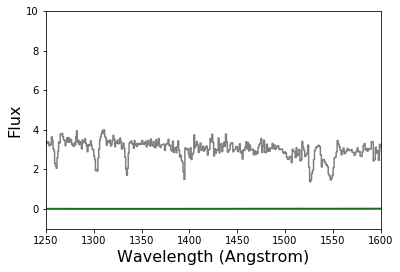

In [106]:
#rest frame wave values
rest_spec = ltsu.rebin_to_rest(collate,trimmed_z, 200*u.km/u.s)  

#the stack!
stack = ltsu.smash_spectra(rest_spec)

waverng = (1250,1600)
stack.plot(xlim=(waverng))

In [105]:
stack.write_to_fits("fullstack.fits")

Wrote spectrum to fullstack.fits
